In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import sys

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
fnames = [f for f in os.listdir('..') if f.startswith('TDA_anomaly_death')]
fnames

['TDA_anomaly_death_3.npy',
 'TDA_anomaly_death_2.npy',
 'TDA_anomaly_death_1.npy']

In [5]:
dicts = {fname.replace('.npy',''):np.load('../'+fname, allow_pickle=True).item() for fname in fnames}

In [6]:
tda_ds = pd.DataFrame(dicts)
tda_ds = tda_ds[sorted(tda_ds.columns)]
tda_ds.index.name = 'Country'
print(tda_ds.shape)
tda_ds.head()

(186, 3)


,TDA_anomaly_death_1,TDA_anomaly_death_2,TDA_anomaly_death_3
Country,,,
Afghanistan,class_1,class_1,class_2
Albania,class_1,class_1,class_2
Algeria,class_1,class_1,class_1
Andorra,class_5,NaN,NaN
Angola,class_1,class_1,class_1


In [7]:
for f in tda_ds.columns:
    tda_ds[f] = [int(x.replace('class','').replace('_','')) if x is not np.nan else None for x in tda_ds[f]]
    tda_ds[f] = tda_ds[f].fillna(tda_ds[f].dropna().max()+1)

In [8]:
cov_ds = pd.read_csv('../Covid_19_aggregated.csv')
print(cov_ds.shape)
cov_ds.head()

(28952, 60)


,Country,Lat,Long,Date,Confirmed,Deaths,Recovered,C1_School closing,C2_Workplace closing,C3_Cancel public events,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,Population,GrowthRate,Area,Density,Airports,GDP
0,Afghanistan,33.0,65.0,01/22/2020,0,0,0,0.0,0.0,0.0,...,NaN,37.746,0.5,64.83,38041.754,1.0233,652230.0,58.3257,22.0,74792.0
1,Afghanistan,33.0,65.0,01/23/2020,0,0,0,0.0,0.0,0.0,...,NaN,37.746,0.5,64.83,38041.754,1.0233,652230.0,58.3257,22.0,74792.0
2,Afghanistan,33.0,65.0,01/24/2020,0,0,0,0.0,0.0,0.0,...,NaN,37.746,0.5,64.83,38041.754,1.0233,652230.0,58.3257,22.0,74792.0
3,Afghanistan,33.0,65.0,01/25/2020,0,0,0,0.0,0.0,0.0,...,NaN,37.746,0.5,64.83,38041.754,1.0233,652230.0,58.3257,22.0,74792.0
4,Afghanistan,33.0,65.0,01/26/2020,0,0,0,0.0,0.0,0.0,...,NaN,37.746,0.5,64.83,38041.754,1.0233,652230.0,58.3257,22.0,74792.0


In [9]:
cov_ds = cov_ds.merge(tda_ds.reset_index())

In [10]:
cov_ds['Date_dt'] = pd.to_datetime(cov_ds['Date'])

In [11]:
tda_ds.columns

Index(['TDA_anomaly_death_1', 'TDA_anomaly_death_2', 'TDA_anomaly_death_3'], dtype='object')

In [12]:
cov_ds['Confirmed_lag1'] = None
for v in cov_ds['Country'].unique():
    cds = cov_ds[cov_ds['Country']==v].sort_values('Date_dt')
    cov_ds.loc[cds.index, 'Confirmed_lag1'] = cds['Confirmed'].shift(1)
#cov_ds['Confirmed_lag1'] = cds['Confirmed'].shift(1)

In [13]:
cov_ds['Confirmed_diff'] = cov_ds['Confirmed']-cov_ds['Confirmed_lag1']

In [14]:
cov_ds = cov_ds[cov_ds['Date_dt']>'2020-01-22']

In [15]:
cov_ds['Confirmed_diff'] = cov_ds['Confirmed_diff'].astype(float)

In [16]:
for f in ['Confirmed','Deaths','Recovered', 'Confirmed_diff']:
    cov_ds[f"{f}_per_kpop"] = cov_ds[f]/cov_ds['Population']
    cov_ds[f"{f}_per_pop"] = cov_ds[f]/cov_ds['Population']/1000
    cov_ds[f"{f}_per_pop_perc"] = cov_ds[f]/cov_ds['Population']/1000*100
    cov_ds[f"{f}_log"] = np.log1p(cov_ds[f])

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log1p
  """
/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


In [17]:
xticks = list(cov_ds['Date_dt'].sort_values().drop_duplicates())[::7]

In [18]:
yticks = np.array([0,1,3,10,30,100,300, 1000,3000, 10000, 30000])

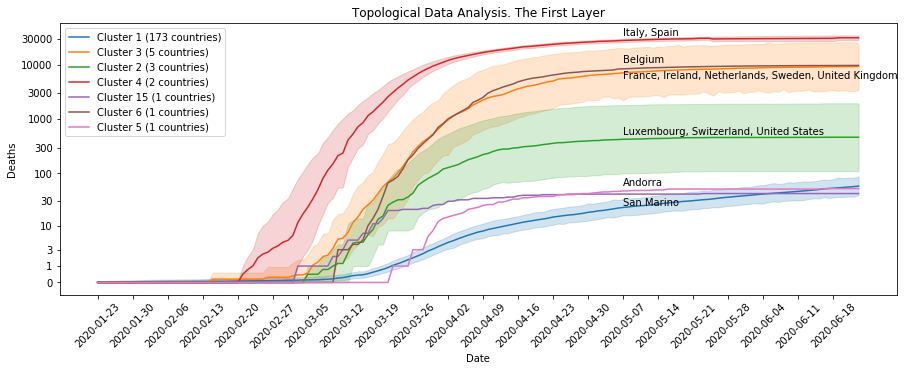

In [44]:
plt.figure(figsize=(15,5))
f = 'TDA_anomaly_death_1'
for v in tda_ds[f].value_counts().index:
    sns.lineplot(x='Date_dt', y='Deaths_log', data=cov_ds[cov_ds[f]==v],
                 label=f"Cluster {v} ({(tda_ds[f]==v).sum()} countries)", palette='Accent',
                err_kws={'alpha':0.2})
plt.xticks(xticks, [str(x)[:10] for x in xticks], rotation=45)
plt.yticks(np.log1p(yticks), yticks)
for v in tda_ds[f].value_counts().index[1:]:
    #if v==tda_ds[f].max():
    #    continue
    mean = cov_ds.loc[(cov_ds[f]==v)&(cov_ds['Date_dt']==xticks[-1]), 'Deaths_log'].mean()
    cntrs = ', '.join(list(tda_ds[tda_ds[f]==v].index))
    plt.text(xticks[-7], mean+0.1 if v not in [3,15] else mean-0.5, cntrs)

plt.title(f"Topological Data Analysis. The First Layer")
plt.ylabel('Deaths')
plt.xlabel('Date')
plt.show()

In [46]:
from datetime import timedelta

In [50]:
tda_ds['TDA_anomaly_death_2'].value_counts()

1.0     158
16.0     13
2.0      10
3.0       3
8.0       1
15.0      1
Name: TDA_anomaly_death_2, dtype: int64

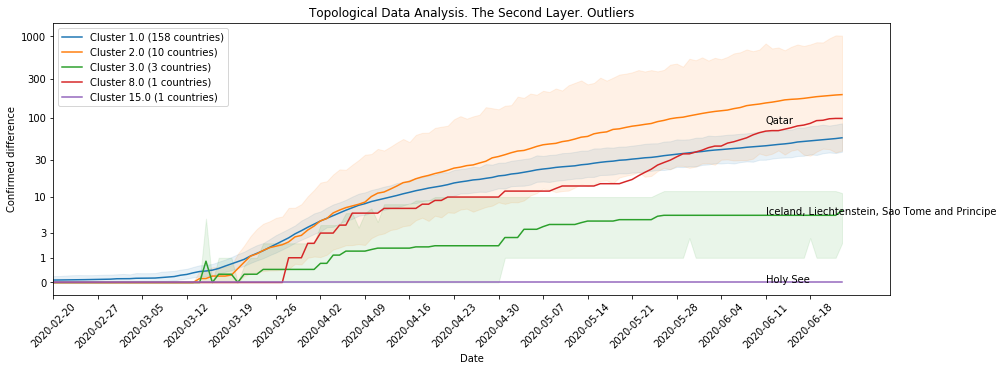

In [59]:
plt.figure(figsize=(15,5))
f = 'TDA_anomaly_death_2'
for v in tda_ds[f].value_counts().index[:]:
    if v==tda_ds[f].max():
        continue
    #pop_mean = cov_ds[cov_ds[f]==v].groupby('Country')['Population'].mean().median()
    #sns.lineplot(x='Date_dt', y='Confirmed_log', data=cov_ds[cov_ds[f]==v],
    sns.lineplot(x='Date_dt', y='Deaths_log', data=cov_ds[cov_ds[f]==v],
    #sns.lineplot(x='Date_dt', y='Confirmed_per_pop', data=cov_ds[cov_ds[f]==v],
                 #label=f"Cluster {v} ({(tda_ds[f]==v).sum()} countries) (median pop: {pop_mean:.0f}"+" k)" if pop_mean is not None else ")",
                 label=f"Cluster {v} ({(tda_ds[f]==v).sum()} countries)",
                 palette='Accent', err_kws={'alpha':0.1})
plt.xticks(xticks[4:], [str(x)[:10] for x in xticks][4:], rotation=45)
plt.xlim((xticks[4], plt.xlim()[-1]))
plt.yticks(np.log1p(yticks[:-3]), yticks[:-3])

for v in tda_ds[f].value_counts().index[3:]:
    if v==tda_ds[f].max():
        continue
    mean = cov_ds.loc[(cov_ds[f]==v)&(cov_ds['Date_dt']==xticks[-1]), 'Deaths_log'].mean()
    cntrs = ', '.join(list(tda_ds[tda_ds[f]==v].index))
    plt.text(xticks[-2], mean, cntrs)
    #plt.text(xticks[-1], mean+0.1, f"Confirmed cases: {np.expm1(mean):.0f}")

plt.title(f"Topological Data Analysis. The Second Layer. Outliers")
plt.ylabel('Confirmed difference')
plt.xlabel('Date')
plt.show()

In [58]:
tda_ds[tda_ds['TDA_anomaly_death_2']==8]

,TDA_anomaly_death_1,TDA_anomaly_death_2,TDA_anomaly_death_3
Country,,,
Qatar,1,8.0,16.0


In [25]:
tda_ds[tda_ds['TDA_anomaly_diff_2'].isin([3,9,15,5])]

,TDA_anomaly_diff_1,TDA_anomaly_diff_2,TDA_anomaly_diff_3,TDA_final
Country,,,,
Andorra,1,5.0,16.0,NaN
Holy See,1,15.0,16.0,NaN
Liechtenstein,1,3.0,16.0,NaN
Luxembourg,1,3.0,16.0,NaN
San Marino,1,9.0,16.0,NaN
Sao Tome and Principe,1,3.0,16.0,NaN
